In [234]:
import SimpleITK as sitk
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

import sys
 
# setting path
sys.path.append('../../algorithms/segmentation')

from segmentation import k_means




## Código para hacer registro

In [284]:
# fixed_image = sitk.ReadImage("../../images/1/FLAIR.nii.gz")
# moving_image = sitk.ReadImage("../../images/1/T1.nii.gz")
image_data_FLAIRR = nib.load('../../images/1/FLAIR.nii.gz').get_fdata()
image_data_T1 = nib.load('../../images/1/T1.nii.gz').get_fdata()

# KMEANS
# image_data_T1 = k_means(image_data_T1, 3, 3)

# # Convertir las matrices tridimensionales en imágenes SimpleITK
fixed_image = sitk.GetImageFromArray(image_data_FLAIRR.astype(np.float32))
moving_image = sitk.GetImageFromArray(image_data_T1.astype(np.float32))

# # Permute the axes of the array to match SimpleITK conventions
fixed_image = sitk.PermuteAxes(fixed_image, [2, 1, 0])
moving_image = sitk.PermuteAxes(moving_image, [2, 1, 0])

# Configurar registro
registration_method = sitk.ImageRegistrationMethod()

# Configurar metrica de similutud y ponderación
registration_method.SetMetricAsMeanSquares()
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)



# Configurar el transformador Rígido
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
registration_method.SetInitialTransform(initial_transform)

# Configurar el optimizador y sus parámetros
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, 
                                                  numberOfIterations=100, 
                                                  convergenceMinimumValue=1e-6, 
                                                  convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Realiza el registro
final_transform = registration_method.Execute(fixed_image, moving_image)

# Aplica la transformación a la imagen movida
registered_image = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkBSpline, 0.0, moving_image.GetPixelID())

# Convert SimpleITK image to NumPy array
registered_array = sitk.GetArrayFromImage(registered_image)

# Permute the axes of the array to match the NIfTI convention
registered_array = np.transpose(registered_array, (2, 1, 0))

# # Create an identity affine matrix
affine_matrix = np.eye(4)

# # Create a NIfTI image using the NumPy array and the affine matrix
nifti_image = nib.Nifti1Image(registered_array, affine_matrix)

# # Save the NIfTI image to a file
nib.save(nifti_image, 'registered_image.nii.gz')



## Función Registro a FLAIR

In [ ]:
def registration(fixed_image, moving_image, type="rigid"):

    # # Convertir las matrices tridimensionales en imágenes SimpleITK
    fixed_image = sitk.GetImageFromArray(fixed_image.astype(np.float32))
    moving_image = sitk.GetImageFromArray(moving_image.astype(np.float32))

    # # Permute the axes of the array to match SimpleITK conventions
    fixed_image = sitk.PermuteAxes(fixed_image, [2, 1, 0])
    moving_image = sitk.PermuteAxes(moving_image, [2, 1, 0])

    # Configurar registro
    registration_method = sitk.ImageRegistrationMethod()

    # Configurar metrica de similutud y ponderación
    registration_method.SetMetricAsMeanSquares()
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)



    # Configurar el transformador Rígido
    initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                        moving_image, 
                                                        sitk.Euler3DTransform(), 
                                                        sitk.CenteredTransformInitializerFilter.GEOMETRY)
    registration_method.SetInitialTransform(initial_transform)

    # Configurar el optimizador y sus parámetros
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, 
                                                    numberOfIterations=100, 
                                                    convergenceMinimumValue=1e-6, 
                                                    convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Realiza el registro
    final_transform = registration_method.Execute(fixed_image, moving_image)

    # Hacer registro rígido o no rígido dependiendo del parámetro tipo
    if(type == "rigid"):
        # Aplica la transformación rígida a la imagen movida
        registered_image = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    else:
        # Aplica la transformación no rígida a la imagen movida
        registered_image = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkBSpline, 0.0, moving_image.GetPixelID())


    # Convertir la imagen SimpleITK a una matriz NumPy
    registered_array = sitk.GetArrayFromImage(registered_image)

    # Permutar los ejes de la matriz para que coincida con la convención NIfTI
    registered_array = np.transpose(registered_array, (2, 1, 0))

    return registered_array

    # # Crear una matriz afín de identidad
    # affine_matrix = np.eye(4)

    # # Crear una imagen NIfTI utilizando la matriz NumPy y la matriz afín
    # nifti_image = nib.Nifti1Image(registered_array, affine_matrix)

    # # Guardar la imagen NIfTI en un archivo
    # nib.save(nifti_image, 'registered_image.nii.gz')

## Registro no rígido

In [214]:
def nonrigid_registration(image_fixed, image_moving):
    # Convertir las matrices tridimensionales en imágenes SimpleITK
    sitk_fixed = sitk.GetImageFromArray(image_fixed.astype(np.float32))
    sitk_moving = sitk.GetImageFromArray(image_moving.astype(np.float32))

    # Crear transformada de registro no rígido
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5, numberOfIterations=100)

    # Establecer el muestreo de la métrica
    registration_method.SetMetricSamplingStrategy(sitk.ImageRegistrationMethod.REGULAR)
    registration_method.SetMetricSamplingPercentage(0.05)

    # Definir los componentes de la transformación
    initial_transform = sitk.TranslationTransform(sitk_fixed.GetDimension())
    bspline_transform = sitk.BSplineTransformInitializer(sitk_fixed, order=3)
    composite_transform = sitk.CompositeTransform([initial_transform, bspline_transform])

    # Realizar el registro no rígido
    registration_method.SetInitialTransform(composite_transform)
    final_transform = registration_method.Execute(sitk_fixed, sitk_moving)

    # Aplicar la transformación al volumen móvil
    registered_image = sitk.Resample(sitk_moving, sitk_fixed, final_transform, sitk.sitkLinear, 0.0, sitk_moving.GetPixelID())

    # Convertir la imagen SimpleITK resultante en una matriz tridimensional
    registered_array = sitk.GetArrayFromImage(registered_image)

    return registered_array

## Registro Rígido

In [4]:
def rigid_registration(image_fixed, image_moving):
    # Convertir las matrices tridimensionales en imágenes SimpleITK
    sitk_fixed = sitk.GetImageFromArray(image_fixed)
    sitk_moving = sitk.GetImageFromArray(image_moving)

    # Crear un transformador de registro rígido
    registration_method = sitk.ImageRegistrationMethod()

    # Definir el tipo de registro y sus parámetros
    registration_method.SetMetricAsMeanSquares()
    registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0, minStep=1e-4, numberOfIterations=100)
    registration_method.SetInitialTransform(sitk.TranslationTransform(sitk_moving.GetDimension()))

    # Realizar el registro
    transform = registration_method.Execute(sitk_fixed, sitk_moving)

    # Aplicar la transformación al volumen móvil
    registered_image = sitk.Resample(sitk_moving, sitk_fixed, transform, sitk.sitkLinear, 0.0, sitk_moving.GetPixelID())

    # Convertir la imagen SimpleITK resultante en una matriz tridimensional
    registered_array = sitk.GetArrayFromImage(registered_image)

    return registered_array

## Plots

In [285]:
image_data = nib.load('./registered_image.nii.gz').get_fdata()
image_data_FLAIRR = nib.load('../../images/1/FLAIR.nii.gz').get_fdata()
image_data_T1 = nib.load('../../images/1/T1.nii.gz').get_fdata()
# image_data_registerd_image = nib.load(registered_image).get_fdata()


# Registrations
# registered_array = nonrigid_registration(image_data_FLAIRR, image_data_T1)

(240, 240, 48)


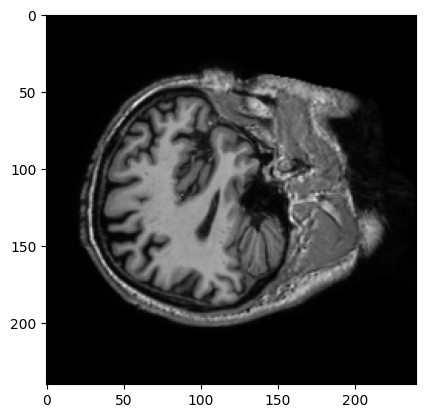

In [219]:
print(registered_array.shape)
plt.imshow(registered_array[:, :, 1], cmap='gray')

# print(image_data.shape)
# plt.imshow(image_data[:, :, 47], cmap='gray')



(240, 240, 48)


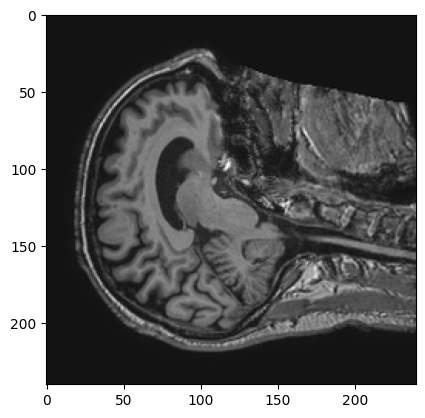

In [286]:
print(image_data.shape)
plt.imshow(image_data[:, :, 30], cmap='gray')

(240, 240, 48)


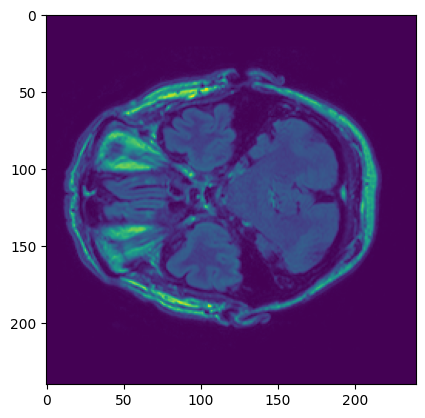

In [60]:
print(image_data_FLAIRR.shape)
plt.imshow(image_data_FLAIRR[:, :, 10])

(256, 256, 192)


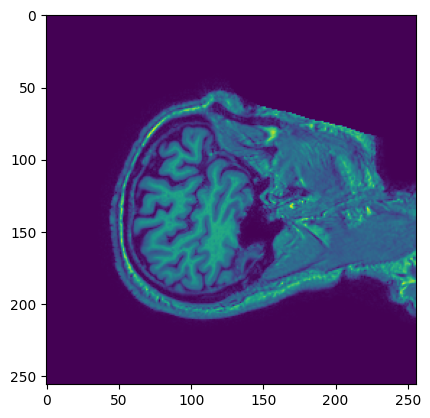

In [162]:
print(image_data_T1.shape)
plt.imshow(image_data_T1[:, :, 47])